In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [14]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Preprocessing
- get rid of nulls
- encoding categorical data

In [17]:
train_df.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked        True
dtype: bool

In [16]:
# any one without a cabin just place None
train_df['Cabin'] = train_df['Cabin'].apply(lambda x: 'None' if pd.isna(x) else x)

In [18]:
train_df.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked        True
dtype: bool

In [19]:
# find the most common location embarked
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

In [20]:
train_df.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

In [22]:
# Age is usually correlated with the amount of money they make and sex. 
# find the average age based on sex and passenger class (1st 2nd or 3rd)
corr_df = train_df.groupby(['Pclass', 'Sex']).Age.mean().reset_index()

def update_age(params):
    pclass = params.iloc[0]
    sex = params.iloc[1]
    age = params.iloc[2]
    if pd.isnull(age):
        age = float(corr_df[(corr_df['Pclass'] == pclass) & (corr_df['Sex'] == sex)]['Age'].iloc[0])
    return age

train_df['Age'] = train_df[['Pclass', 'Sex', 'Age']].apply(lambda x : update_age(x), axis = 1)

In [23]:
train_df.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

In [ ]:
train_df = train_df.drop(columns=['Name', 'Ticket', 'Cabin'])
train_df.head()

## Data Analysis

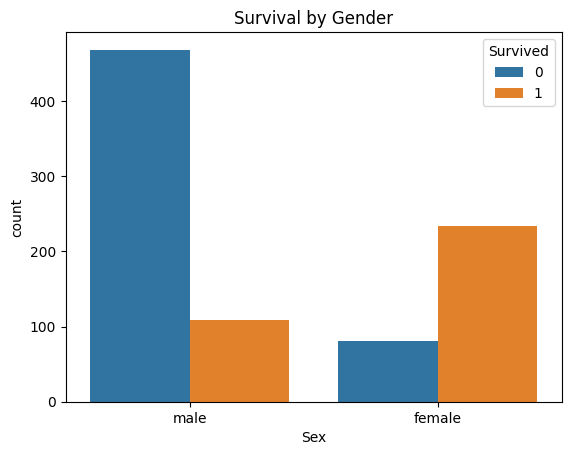

In [24]:
sns.countplot(x='Sex', hue='Survived', data=train_df)
plt.title('Survival by Gender')
plt.show()

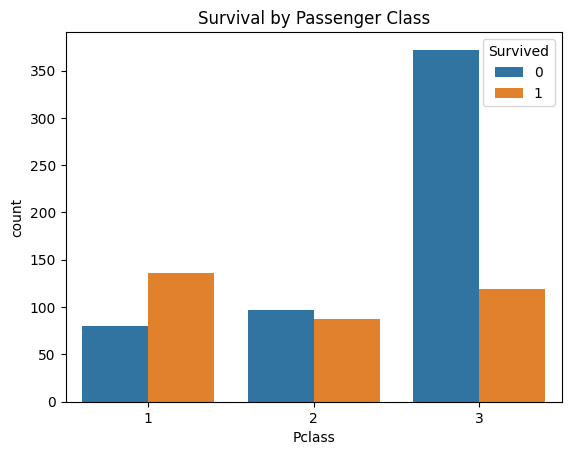

In [25]:
sns.countplot(x='Pclass', hue='Survived', data=train_df)
plt.title('Survival by Passenger Class')
plt.show()

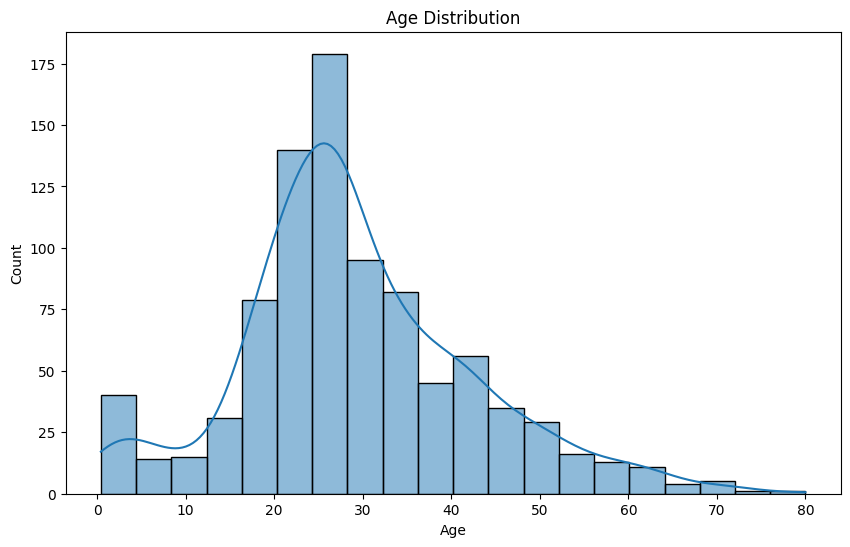

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='Age', bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [27]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.318643,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.281103,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,21.750000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,26.507589,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,36.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [32]:
train_df[['Age', 'Pclass']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Age', ascending=False)

,Pclass,Age
0,1,38.378866
1,2,29.907295
2,3,25.112288


In [33]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


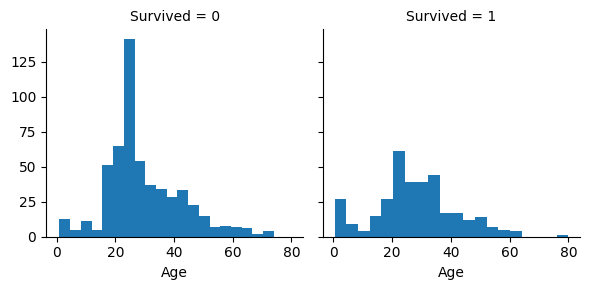

In [34]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

## One hot encode categorical data 

In [40]:
# one hot encode sex and embarked columns
encoder = OneHotEncoder()
sex_arr = encoder.fit_transform(train_df[['Sex']]).toarray()

# split sex column into male and female columns
categories = ['female', 'male']
for i in range(len(sex_arr.T)):
    train_df[categories[i]] = sex_arr.T[i]


In [41]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,female,male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S,1.0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S,0.0,1.0


In [42]:
emb_arr = encoder.fit_transform(train_df[['Embarked']]).toarray()

# split sex column into male and female columns
categories = ['C','S','Q','N']
for i in range(len(emb_arr.T)):
    train_df[categories[i]] = emb_arr.T[i]

In [43]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,female,male,C,S,Q
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S,0.0,1.0,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,0.0,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S,1.0,0.0,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0,0.0,0.0,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S,0.0,1.0,0.0,0.0,1.0


In [45]:
# remove uneeded columns
train_df = train_df.drop(columns=['Sex', 'Embarked'])
train_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,S,Q
0,1,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,2,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,3,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,4,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,5,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0
